### <b>Word2Vec</b>

<br>

##### What is Word2Vec ? 

Word2Vec is a Word Embedding that´s applied on NLP tasks, across Embedding We be able extract representation on words in text, Beyond be most user Embedding for NLP, let´s go studing this concept. 
 
<br>

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

<br>


#### How does Word2Vec work?

Word2Vec is a method to construct such an embedding. It can be obtained using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW)
CBOW Model: This method takes the context of each word as the input and tries to predict the word corresponding to the context. Consider our example: Have a great day.
Let the input to the Neural Network be the word, great. Notice that here we are trying to predict a target word (day) using a single context input word great. More specifically, we use the one hot encoding of the input word and measure the output error compared to one hot encoding of the target word (day). In the process of predicting the target word, we learn the vector representation of the target word.
Let us look deeper into the actual architecture.

<br>


<p align=center>
<img src="https://miro.medium.com/max/700/0*3DFDpaXoglalyB4c.png" width="70%"></p>

<br>

The input or the context word is a one hot encoded vector of size V. The hidden layer contains N neurons and the output is again a V length vector with the elements being the softmax values.
Let’s get the terms in the picture right:
- Wvn is the weight matrix that maps the input x to the hidden layer (V*N dimensional matrix)
-W`nv is the weight matrix that maps the hidden layer outputs to the final output layer (N*V dimensional matrix)
I won’t get into the mathematics. We’ll just get an idea of what’s going on.
The hidden layer neurons just copy the weighted sum of inputs to the next layer. There is no activation like sigmoid, tanh or ReLU. The only non-linearity is the softmax calculations in the output layer.
But, the above model used a single context word to predict the target. We can use multiple context words to do the same.

<br>

<p align=center>
<img src="
https://www.researchgate.net/profile/Olivier_Caelen/publication/322709818/figure/fig1/AS:731527327514624@1551421114982/Architecture-of-Word2Vec-with-CBOW-technique.ppm
" width="40%"></p>

<br>


The above model takes C context words. When Wvn is used to calculate hidden layer inputs, we take an average over all these C context word inputs.
So, we have seen how word representations are generated using the context words. But there’s one more way we can do the same. We can use the target word (whose representation we want to generate) to predict the context and in the process, we produce the representations. Another variant, called Skip Gram model does this.

<br>

#### Skip-Gram model


This looks like multiple-context CBOW model just got flipped. To some extent that is true.
We input the target word into the network. The model outputs C probability distributions. What does this mean?
For each context position, we get C probability distributions of V probabilities, one for each word.


<br>

<p align=center>
<img src="https://miro.medium.com/max/600/0*wzqwkNA3ylFwmB6D.png" width="50%"></p>

<br>



#### Who wins?

Both have their own advantages and disadvantages. According to Mikolov, Skip Gram works well with small amount of data and is found to represent rare words well.
On the other hand, CBOW is faster and has better representations for more frequent words.


<br>

<hr>



In [1]:
import os 
import re 
import string 
import time 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


import nltk 
import gensim 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# seed 
seed = 42
np.random.seed(seed)

In [3]:
path = '/content/drive/My Drive/Deep Learning - Projetos/Embeddings /Musical_instruments_reviews.csv'
data = pd.read_csv(path)
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
data.columns = data.columns.str.lower()

In [5]:
cols_drop = ['reviewerid','asin','reviewername','helpful','unixreviewtime', 'reviewtime']
data.drop(columns=cols_drop, axis=1, inplace=True)

In [6]:
data['reviewtext'] = data['reviewtext'] + ' ' + data['summary']
data.drop('summary', axis=1, inplace=True)

data['reviewtext'] = data['reviewtext'].astype(str)

In [7]:
# create corpus 
document = data['reviewtext']

corpus = []
for sentence in document:
  corpus.append(sentence.split())

In [8]:
corpus[0]

['Not',
 'much',
 'to',
 'write',
 'about',
 'here,',
 'but',
 'it',
 'does',
 'exactly',
 'what',
 "it's",
 'supposed',
 'to.',
 'filters',
 'out',
 'the',
 'pop',
 'sounds.',
 'now',
 'my',
 'recordings',
 'are',
 'much',
 'more',
 'crisp.',
 'it',
 'is',
 'one',
 'of',
 'the',
 'lowest',
 'prices',
 'pop',
 'filters',
 'on',
 'amazon',
 'so',
 'might',
 'as',
 'well',
 'buy',
 'it,',
 'they',
 'honestly',
 'work',
 'the',
 'same',
 'despite',
 'their',
 'pricing,',
 'good']

<hr>
<br>

### Word2Vec 

Explanation about parameters of Word2Vec: 

* <b> Size </b>: The size of the dense vector to represent each token or word (i.e. the context or neighboring words) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word). If you have limited data, then size should be a much smaller value since you would only have so many unique neighbors for a given word. If you have lots of data, it’s good to experiment with various sizes. A value of 100–150 has worked well for me for similarity lookups.

<br>

* <b> Window </b>: The maximum distance between the target word and its neighboring word. If your neighbor’s position is greater than the maximum window width to the left or the right, then, some neighbors would not be considered as being related to the target word. In theory, a smaller window should give you terms that are more related. Again, if your data is not sparse, then the window size should not matter too much, as long as it’s not overly narrow or overly broad. If you are not too sure about this, just use the default value.

<br>

* <b> Min_count</b>: Minimium frequency count of words. The model would ignore words that do not satisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model in terms of your final results. The settings here probably has more of an effect on memory usage and storage requirements of the model files.

<br> 

* <b> Workers </b>: How many threads to use behind the scenes?

<br> 

* <b> Iter </b>: Number of iterations (epochs) over the corpus. 5 is a good starting point.

<br>

* <b> Sg </b>: This parameter to be able choose our algorithm, can choose both CBOW or Skip-gram. (CBOW=0 |Skip-Gram=1)  

<br>
<hr>

In [9]:
# Word2Vec 
model = Word2Vec(sentences=corpus, size=150, window=10, min_count=2, workers=5, iter=10, sg=0, seed=42)

In [10]:
# vocabulary learned
vocab = list(model.wv.vocab)
print(vocab)

['Not', 'much', 'to', 'write', 'about', 'here,', 'but', 'it', 'does', 'exactly', 'what', "it's", 'supposed', 'to.', 'filters', 'out', 'the', 'pop', 'sounds.', 'now', 'my', 'recordings', 'are', 'more', 'crisp.', 'is', 'one', 'of', 'lowest', 'prices', 'on', 'amazon', 'so', 'might', 'as', 'well', 'buy', 'it,', 'they', 'honestly', 'work', 'same', 'despite', 'their', 'pricing,', 'good', 'The', 'product', 'should', 'and', 'quite', 'affordable.I', 'did', 'not', 'realized', 'was', 'double', 'screened', 'until', 'arrived,', 'even', 'better', 'than', 'I', 'had', 'an', 'added', 'bonus,', 'screens', 'carries', 'a', 'small', 'hint', 'smell', 'old', 'candy', 'used', 'buy,', 'for', 'sake,', 'cannot', 'stop', 'putting', 'filter', 'next', 'nose', 'smelling', 'after', 'recording.', 'you', 'needed', 'filter,', 'this', 'will', 'just', 'expensive', 'ones,', 'may', 'come', 'with', 'pleasing', 'like', 'mine', 'product!', ':]', 'Jake', 'primary', 'job', 'device', 'block', 'breath', 'that', 'would', 'otherwise

In [11]:
# word embedding specify 
print(model['product'])

[-0.72567797 -0.07258378  0.06486934 -1.4165906  -0.59376043 -0.54533523
 -1.2422066   0.0745732   1.2693793   0.48747656 -0.79385024 -1.3183563
  0.68236834  0.7302492  -0.32409018  0.5642163  -0.21450092  0.25278646
  1.1994176  -0.56639224 -0.9247094  -1.1669632  -0.15359136  0.7029243
  0.16487648  1.0188729   0.03284046  0.14540473 -0.8251565  -1.1987996
  1.0331037   1.2302513  -0.14102417 -0.62813115  1.4703873  -0.25799713
 -0.03715021 -2.3748345   0.5490114  -1.9018321   0.31887966 -1.8795857
 -0.30401665  0.26423433  1.6782098   1.1369122  -0.20821147  0.94523627
 -0.051891    0.1950746   1.3259581  -0.7097333   0.1735357  -0.41055152
  0.7832278  -1.6833656   0.5533354  -0.53486645  0.7029572  -0.6771257
  0.30646676 -0.7684554   1.8795353   0.8197498  -0.01567808  0.2628857
  0.09912908  0.46952608 -0.4430097   0.60546374 -0.5675991   0.16579333
 -1.5485915  -0.81668115  0.4383012   0.80805475  1.7668523  -0.7511212
  0.4795635   0.11962099  0.22353299 -0.70523417 -1.582229

In [12]:
# salve model 
model.wv.save_word2vec_format('model.bin')

In [13]:
new_model = gensim.models.KeyedVectors.load_word2vec_format('model.bin')

In [14]:
new_model.wv.similarity(w1='product', w2='bad')

0.3222769

In [15]:
# save in txt
model.wv.save_word2vec_format('model.txt', binary=False)

In [16]:
# load txt 
new_model = gensim.models.KeyedVectors.load_word2vec_format('model.txt')

<hr>
<br>

##### <b> Similar context </b> 

Let´s see the most similar words in each word in our vocabulary

* Similarity is calculate across cosine using word vectors (Embeddings) 

In [17]:
w1 = 'product'
model.wv.most_similar(positive=w1)

[('item', 0.8093810081481934),
 ('product,', 0.7302640080451965),
 ('product.', 0.6977494359016418),
 ('item.', 0.6859559416770935),
 ('seller', 0.6540715098381042),
 ('extender', 0.6272962689399719),
 ('company', 0.6166255474090576),
 ('purchase.', 0.6146968007087708),
 ('one.', 0.5914859771728516),
 ('deal.', 0.5881485342979431)]

In [18]:
w1 = 'amazon'
model.wv.most_similar(positive=w1)

[('Amazon,', 0.8293683528900146),
 ('Amazon', 0.8159904479980469),
 ('Free', 0.7912590503692627),
 ('$2', 0.7843044996261597),
 ('sale', 0.7803460359573364),
 ('Amazon.', 0.7694070339202881),
 ('$30', 0.758276104927063),
 ('shipping.', 0.7572162747383118),
 ('$5', 0.746415913105011),
 ('$40', 0.7410605549812317)]

In [19]:
# top 5 
w1 = 'music'
model.wv.most_similar(positive=w1, topn=5)

[('home', 0.6874479055404663),
 ('studio.', 0.6353310346603394),
 ('band', 0.621025025844574),
 ('local', 0.6190083622932434),
 ('studio', 0.6159166693687439)]

In [20]:
# Positive and Negative 
model.most_similar(positive=['instrument', 'sound'], negative=['bad'])

[('instrument.', 0.6132300496101379),
 ('bass', 0.571622371673584),
 ('taxing', 0.5684571862220764),
 ('bass,', 0.5519868731498718),
 ('soundhole.', 0.5377969145774841),
 ('instruments.', 0.5278424620628357),
 ('contour', 0.5209226012229919),
 ('growl', 0.5204681754112244),
 ('acoustic', 0.5125704407691956),
 ('playing!', 0.5054688453674316)]

<hr>
<br>

#### <b> Similarity between words </b>

We Gonna Check it similarity between different words 


In [21]:
w1 = 'product'
w2 = 'good'
model.wv.similarity(w1=w1, w2=w2)

0.22747348

In [22]:
w1='studio'
w2='best'
model.wv.similarity(w1,w2)

0.024785964

In [23]:
w1='money'
w2='item'
model.wv.similarity(w1,w2)

0.4136492

In [24]:
w1='price'
w2='good'
model.wv.similarity(w1,w2)

0.29567206

<br>
<hr>

#### Visualize Word Vectors 

We can create a 2-dimensional PCA model of the word vectors using the scikit-learn PCA

<br>

In [25]:
class GensimWord2vecPlotter(object):

    __slots__ = ["model", "words", "result", "_tem"]

    def __init__(self, model):
        self.model = model
        self.words = None
        self.result = None
        self._tem = self.preprocess()

    def plot_scatter_words(self, Size=80):
        SIZE = Size
        words = self.words
        result = self.result

        for i, word in enumerate(words):
            if i == SIZE:
                break
            
            plt.annotate(word,
                         xy=(result[i, 0], result[i, 1]),
                         horizontalalignment='left',verticalalignment='bottom')

        plt.scatter(result[:SIZE, 0], result[:SIZE, 1],s=(40,))
        plt.title("Word Vectors")
        plt.grid(True, alpha=1)
        plt.legend()
        plt.grid(False)
        plt.show()


    def preprocess(self):
        """
        Pre Processing sets all the variable in constructor
        :return: None
        """
        model = self.model
        X = model[model.wv.vocab]
        pca = PCA(n_components=2)
        result = pca.fit_transform(X)
        words = list(model.wv.vocab)
        self.words = words
        self.result = result

    def getPandasDF(self):
        result = self.result
        words = self.words
        
        x = [result[i, 0]  for i, word in enumerate(words)  ]
        y = [result[i, 1]  for i, word in enumerate(words)  ]

        wordsdf = pd.DataFrame(data={
            "words":words,
            "x":x,
            "y":y
        })
        
        return wordsdf


    def plot_catter(self):

        model = self.model
        X = model[model.wv.vocab]
        result = self.result
        words = self.words

        x = [result[i, 0]  for i, word in enumerate(words)  ]
        y = [result[i, 1]  for i, word in enumerate(words)  ]

        wordsdf = pd.DataFrame(data={
            "words":words,
            "x":x,
            "y":y
        })
        wordsdf.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [26]:
visualize = GensimWord2vecPlotter(model=model)

No handles with labels found to put in legend.


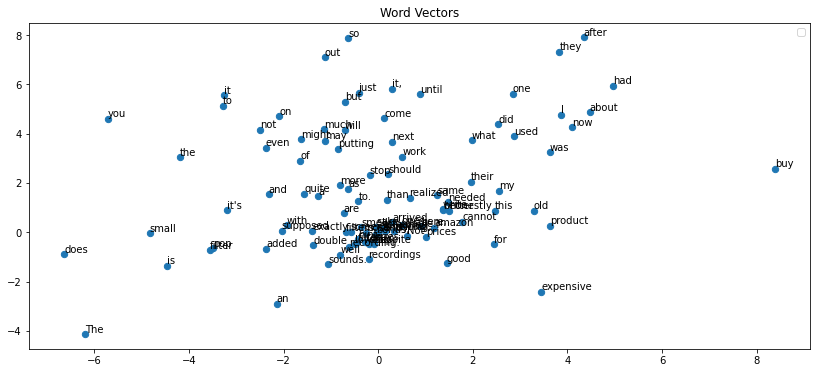

In [27]:
plt.figure(figsize=(14,6))
visualize.plot_scatter_words(Size=100)

<hr>
<br>

#### Pre-Trained Word2Vec 

A pre-trained model is nothing more than a file containing tokens and their associated word vectors. The pre-trained Google word2vec model was trained on Google news data (about 100 billion words); it contains 3 million words and phrases and was fit using 300-dimensional word vectors.

<br>

In [28]:
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [29]:
# Google Word2Vec 
model = api.load('word2vec-google-news-300')

[=================================================-] 98.5% 1637.4/1662.8MB downloaded


In [30]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.7118192911148071)]


<hr>
<br>


#### Glove with Gensim 


* convert from glove file to word2vec 

In [31]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-09-17 18:34:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-17 18:34:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-17 18:34:41--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [32]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.txt.word2vec'

# convert 
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 300)

In [33]:
# using glove 
filename = 'glove.6B.300d.txt.word2vec'

model = KeyedVectors.load_word2vec_format(filename, binary=False)
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.6713277101516724)]


<hr>
<br>
<br>
<hr>
<br>

### Word2vec Embedding + LSTM 

In [34]:
import os 
import re
import string
import random 
import time 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')


import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, SpatialDropout1D
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Dropout, GRU, Bidirectional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
path = '/content/drive/My Drive/Deep Learning - Projetos/Classificação de Texto - Twitter /training.1600000.processed.noemoticon.csv'
data = pd.read_csv(path, encoding='latin', header=None)

In [36]:
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
data.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [37]:
data.drop(['id', 'date', 'query', 'user_id'], axis=1, inplace=True)

In [38]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [39]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else: 
        tokens.append(token)
  return " ".join(tokens)

In [40]:
data['text'] = data['text'].apply(lambda x: preprocess(x, stem=False))

In [41]:
X = data['text']
y = data['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

print('Train: {}'.format(X_train.shape))
print('Teste: {}'.format(X_test.shape))

Train: (1120000,)
Teste: (480000,)


In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Índice de palavras 
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Vocabulary size: {}'.format(vocab_size))

Vocabulary size: 266578


In [43]:
max_sequence_length = 50 

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')


print('Maior Sequência: {}'.format(len(max(data.text))))
print('Sequência definida: {}'.format(max_sequence_length))

Maior Sequência: 58
Sequência definida: 50


In [44]:
EMBEDDING_DIM = 300
vocab_size = 266578

In [45]:
# Word2vec 
%%time 

# Corpus 
document = data['text']
corpus = []
for word in document:
  corpus.append(word.split())

word2vec_embedding = Word2Vec(sentences=corpus, size=300, window=5, min_count=2, iter=10, sg=1, seed=42)

CPU times: user 21min 14s, sys: 2.26 s, total: 21min 17s
Wall time: 11min 5s


In [46]:
word2vec_embedding.wv.save_word2vec_format('model.bin')

In [47]:
embeddings_index = {}

f = open('model.bin')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Find {} Word vectors.'.format(len(embeddings_index)))

Find 121463 Word vectors.


In [48]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [49]:
word2vec_layer = Embedding(input_dim=vocab_size,
                           output_dim=EMBEDDING_DIM,
                           input_length=max_sequence_length,
                           weights=[embedding_matrix],
                           trainable=False)

In [50]:
# LSTM with Word2Vec 

model = Sequential()
model.add(Input(shape=max_sequence_length))
model.add(word2vec_layer) # Word2Vec 
model.add(SpatialDropout1D(0.20))
model.add(LSTM(units=128, recurrent_dropout=0.20))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           79973400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [51]:

%%time


model.compile(optimizer=Adam(0.001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])


history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
1094/1094 [==============================] - 197s 180ms/step - loss: 0.5032 - accuracy: 0.7511 - val_loss: 0.4792 - val_accuracy: 0.7686
Epoch 2/10
1094/1094 [==============================] - 197s 180ms/step - loss: 0.4697 - accuracy: 0.7754 - val_loss: 0.4530 - val_accuracy: 0.7844
Epoch 3/10
1094/1094 [==============================] - 199s 181ms/step - loss: 0.4586 - accuracy: 0.7820 - val_loss: 0.4477 - val_accuracy: 0.7901
Epoch 4/10
1094/1094 [==============================] - 197s 180ms/step - loss: 0.4514 - accuracy: 0.7861 - val_loss: 0.4392 - val_accuracy: 0.7915
Epoch 5/10
1094/1094 [==============================] - 199s 182ms/step - loss: 0.4465 - accuracy: 0.7892 - val_loss: 0.4373 - val_accuracy: 0.7948
Epoch 6/10
1094/1094 [==============================] - 197s 180ms/step - loss: 0.4414 - accuracy: 0.7920 - val_loss: 0.4347 - val_accuracy: 0.7950
Epoch 7/10
1094/1094 [==============================] - 197s 181ms/step - loss: 0.4380 - accuracy: 0.7939 - val_